In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
import random

from gym import wrappers
envCartPole = gym.make('CartPole-v1')
envCartPole.seed(50) #Set the seed to keep the environment consistent across runs

[50]

In [ ]:
#Global Variables
EPISODES = 500
TRAIN_END = 0

In [ ]:
#Hyper Parameters
def discount_rate(): #Gamma
    return 0.95

def learning_rate(): #Alpha
    return 0.001

def batch_size(): #Size of the batch used in the experience replay
    return 24

In [ ]:
class DeepQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon,epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.loss = []
        
    def build_model(self):
        model = keras.Sequential() #linear stack of layers https://keras.io/models/sequential/
        model.add(keras.layers.Dense(24, input_dim=self.nS, activation='relu')) #[Input] -> Layer 1
        #   Dense: Densely connected layer https://keras.io/layers/core/
        #   24: Number of neurons
        #   input_dim: Number of input variables
        #   activation: Rectified Linear Unit (relu) ranges >= 0
        model.add(keras.layers.Dense(24, activation='relu')) #Layer 2 -> 3
        model.add(keras.layers.Dense(self.nA, activation='linear')) #Layer 3 -> [output]
        #   Size has to match the output (different actions)
        #   Linear activation on the last layer
        model.compile(loss='mean_squared_error', #Loss function: Mean Squared Error
                      optimizer=keras.optimizers.Adam(lr=self.alpha)) #Optimaizer: Adam (Feel free to check other options)
        return model

    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA) #Explore
        action_vals = self.model.predict(state) #Exploit: Use the NN to predict the correct action from this state
        return np.argmax(action_vals[0])

    def test_action(self, state): #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, batch_size):
        #Execute the experience replay
        minibatch = random.sample( self.memory, batch_size ) #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nS)) #States
        nst = np.zeros( (0,self.nS) )#Next States
        for i in range(len(np_array)): #Creating the state and next state np arrays
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)
        st_predict = self.model.predict(st) #Here is the speedup! I can predict on the ENTIRE batch
        nst_predict = self.model.predict(nst)
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
            else:   #Non terminal
                target = reward + self.gamma * np.amax(nst_action_predict_model)
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1 #Epochs is the number or iterations
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
#Create the agent
nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions
dqn1 = DeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.005, 0.995 )
dqn2 = DeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.005, 0.995 )

batch_size = batch_size()

In [ ]:
#Training
rewards = [] #Store rewards for graphing
epsilons = [] # Store the Explore/Exploit
TEST_Episodes = 0
for e in range(EPISODES):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS]) # Resize to store in memory to pass to .predict
    tot_rewards = 0
    prev_action=0;
    for time in range(210): #200 is when you "solve" the game. This can continue forever as far as I know
        action1 = dqn1.action(state)
        action2 = dqn2.action(state)
        if ((action1==0 and action2==0) or (action1==1 and action2==1)):
            action = prev_action
        elif (action1==1 and action2==0):   
            action = 0
        else:
            action = 1  
        prev_action = action      
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn1.store(state, action1, reward, nstate, done) # Resize to store in memory to pass to .predict
        dqn2.store(state, action2, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
        #done: CartPole fell. 
        #time == 209: CartPole stayed upright
        if done or time == 209:
            rewards.append(tot_rewards)
            epsilons.append(dqn1.epsilon)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn1.epsilon))
            break
        #Experience Replay
        if len(dqn1.memory) > batch_size:
            dqn1.experience_replay(batch_size)
        if len(dqn2.memory) > batch_size:
            dqn2.experience_replay(batch_size)
    #If our current NN passes we are done
    #I am going to use the last 5 runs
    if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
        #Set the rest of the EPISODES for testing
        TEST_Episodes = EPISODES - e
        TRAIN_END = e
        break

episode: 0/500, score: 8.0, e: 1
episode: 1/500, score: 9.0, e: 1
episode: 2/500, score: 20.0, e: 0.9416228069143757
episode: 3/500, score: 15.0, e: 0.8778091417340573
episode: 4/500, score: 18.0, e: 0.8061065909263957
episode: 5/500, score: 10.0, e: 0.7705488893118823
episode: 6/500, score: 8.0, e: 0.7439808620067382
episode: 7/500, score: 10.0, e: 0.7111635524897149
episode: 8/500, score: 19.0, e: 0.6498078359349755
episode: 9/500, score: 13.0, e: 0.6118738784280476
episode: 10/500, score: 10.0, e: 0.5848838636585911
episode: 11/500, score: 9.0, e: 0.5618938591163328
episode: 12/500, score: 9.0, e: 0.5398075216808175
episode: 13/500, score: 25.0, e: 0.47862223409330756
episode: 14/500, score: 8.0, e: 0.46211964903917074
episode: 15/500, score: 11.0, e: 0.43952667968844233
episode: 16/500, score: 10.0, e: 0.42013897252428334
episode: 17/500, score: 9.0, e: 0.4036245882390106
episode: 18/500, score: 10.0, e: 0.3858205374665315
episode: 19/500, score: 10.0, e: 0.36880183088056995
episod

In [ ]:
#Test the agent that was trained
#   In this section we ALWAYS use exploit don't train any more
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    prev_action=0
    for t_test in range(210):
        action1 = dqn1.test_action(state)
        action2 = dqn2.test_action(state)
        if ((action1==0 and action2==0) or (action1==1 and action2==1)):
            action = prev_action
        elif (action1==1 and action2==0):   
            action = 0
        else:
            action = 1  
        prev_action = action      
 
 #       action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        #DON'T STORE ANYTHING DURING TESTING
        state = nstate
        #done: CartPole fell. 
        #t_test == 209: CartPole stayed upright
        if done or t_test == 209: 
            rewards.append(tot_rewards)
            epsilons.append(0) #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e_test, TEST_Episodes, tot_rewards, 0))
            break;

episode: 0/375, score: 210.0, e: 0
episode: 1/375, score: 210.0, e: 0
episode: 2/375, score: 210.0, e: 0
episode: 3/375, score: 210.0, e: 0
episode: 4/375, score: 210.0, e: 0
episode: 5/375, score: 210.0, e: 0
episode: 6/375, score: 210.0, e: 0
episode: 7/375, score: 210.0, e: 0
episode: 8/375, score: 210.0, e: 0
episode: 9/375, score: 210.0, e: 0
episode: 10/375, score: 210.0, e: 0
episode: 11/375, score: 210.0, e: 0
episode: 12/375, score: 210.0, e: 0
episode: 13/375, score: 210.0, e: 0
episode: 14/375, score: 210.0, e: 0
episode: 15/375, score: 210.0, e: 0
episode: 16/375, score: 210.0, e: 0
episode: 17/375, score: 210.0, e: 0
episode: 18/375, score: 210.0, e: 0
episode: 19/375, score: 210.0, e: 0
episode: 20/375, score: 210.0, e: 0
episode: 21/375, score: 210.0, e: 0
episode: 22/375, score: 210.0, e: 0
episode: 23/375, score: 210.0, e: 0
episode: 24/375, score: 210.0, e: 0
episode: 25/375, score: 210.0, e: 0
episode: 26/375, score: 210.0, e: 0
episode: 27/375, score: 210.0, e: 0
ep

**Results**  
Here is a graph of the results. If everything was done correctly you should see the rewards over the red line.  

Black: This is the 100 episode rolling average  
Red: This is the "solved" line at 195  
Blue: This is the reward for each episode  
Green: This is the value of epsilon scaled by 200  
Yellow: This is where the tests started.

In [ ]:
"""
rolling_average = np.convolve(rewards, np.ones(100)/100)

plt.plot(rewards)
plt.plot(rolling_average, color='black')
plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TRAIN_END, color='y', linestyle='-')
plt.xlim( (0,EPISODES) )
plt.ylim( (0,220) )
plt.show()


envCartPole.close()
"""

"\nrolling_average = np.convolve(rewards, np.ones(100)/100)\n\nplt.plot(rewards)\nplt.plot(rolling_average, color='black')\nplt.axhline(y=195, color='r', linestyle='-') #Solved Line\n#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range\neps_graph = [200*x for x in epsilons]\nplt.plot(eps_graph, color='g', linestyle='-')\n#Plot the line where TESTING begins\nplt.axvline(x=TRAIN_END, color='y', linestyle='-')\nplt.xlim( (0,EPISODES) )\nplt.ylim( (0,220) )\nplt.show()\n\n\nenvCartPole.close()\n"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#np.save('/content/drive/My Drive/db/dqn/rewards_cs1',rewards)
#np.save('/content/drive/My Drive/db/dqn/TRAIN_END_cs1',TRAIN_END)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


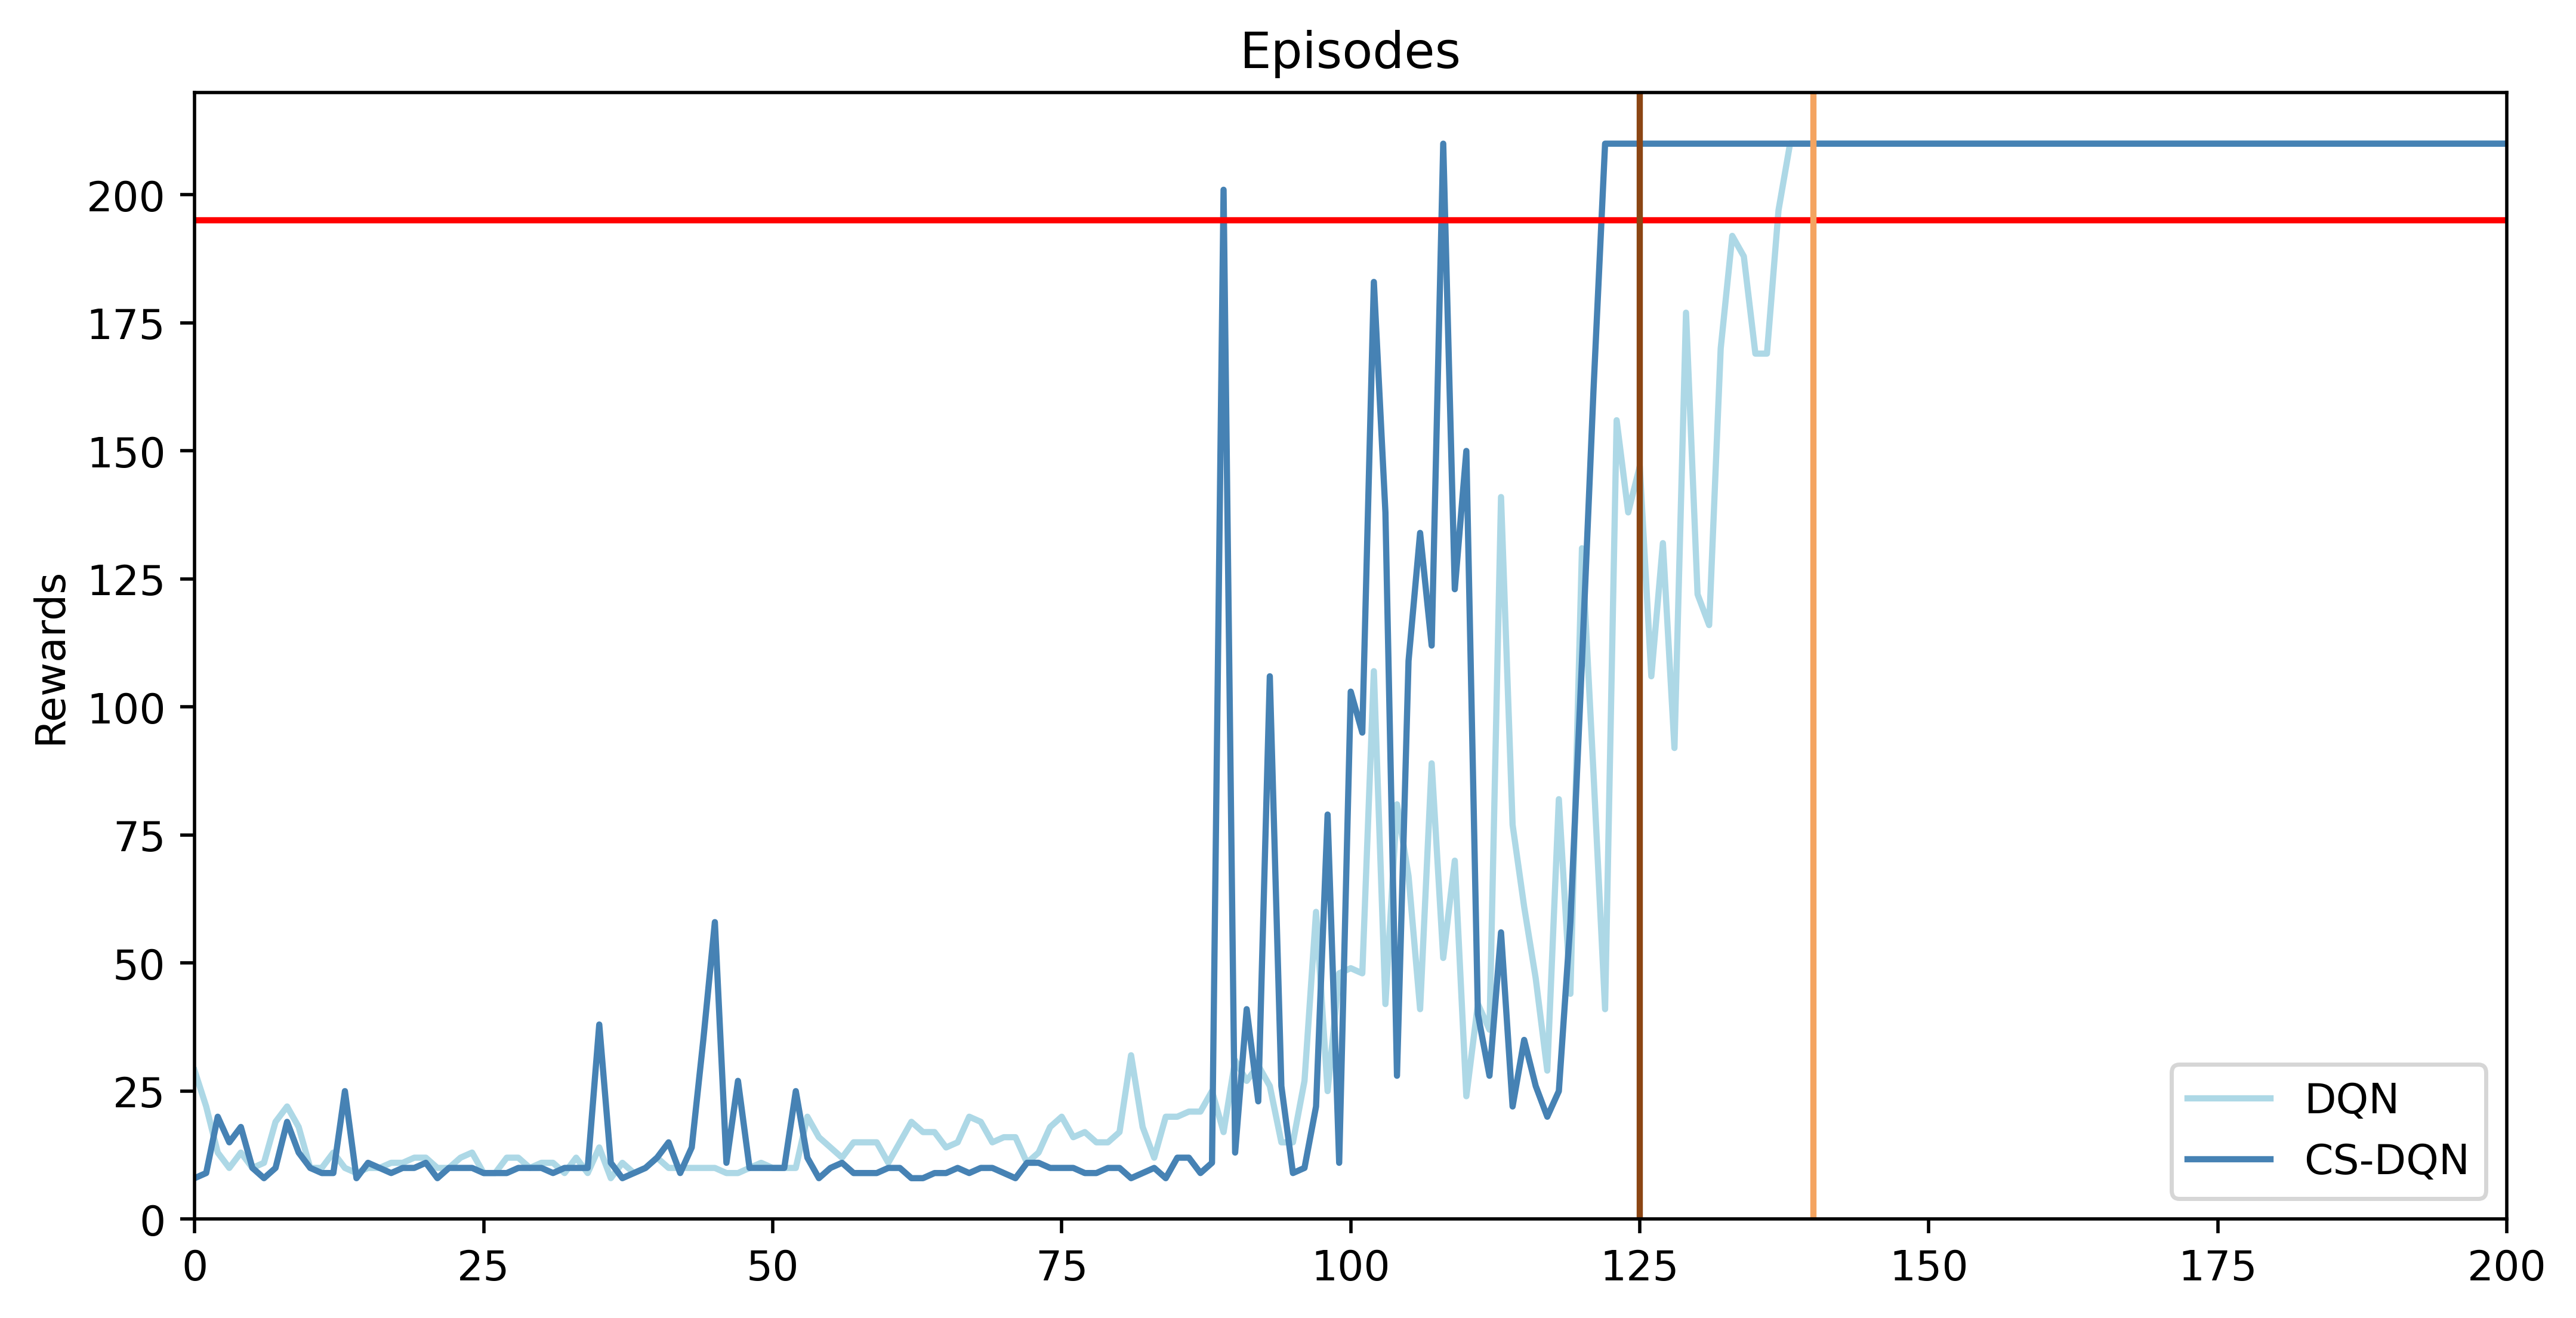

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5),dpi=500)

r_old=np.load('/content/drive/My Drive/db/dqn/rewards.npy')
r_new=np.load('/content/drive/My Drive/db/dqn/rewards_cs1.npy')
TE_old=np.load('/content/drive/My Drive/db/dqn/TRAIN_END.npy')
TE_new=np.load('/content/drive/My Drive/db/dqn/TRAIN_END_cs1.npy')

#rolling_average1 = np.convolve(r_old, np.ones(100)/100)
#rolling_average2 = np.convolve(r_new, np.ones(100)/100)

plt.plot(r_old, color= 'lightblue',label='DQN')
plt.plot(r_new, color='steelblue',label='CS-DQN')
#plt.plot(rolling_average1, color='grey')
#plt.plot(rolling_average1, color='black')
plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range
#eps_graph = [200*x for x in epsilons]
#plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TE_old, color='sandybrown', linestyle='-')
plt.axvline(x=TE_new, color='saddlebrown', linestyle='-')
plt.xlim( (0,200) )
plt.ylim( (0,220) )
plt.ylabel('Rewards')
plt.title('Episodes')
plt.legend()

plt.show()

**Changes**  
*hyper parameters*: You can alter alpha, gamma, batch size, and episode length to see what differences the algorithm returns.  
*Training End*: You can also change the line where I only check the last 5 runs before switching to testing mode (if len(rewards) > 5 and np.average(rewards[-5:]) > 195:) as that doesn't prove it was solved. The reason I did this was because I wanted to limit the amount of runs I made.  

**Conclusion**  
This is a Deep Q-Network implementation. There are some changes you can make here and there but it follows the paper. Hopefully, you were able to understand the code as well as make your own version to compare with this one.

**Reference**  
Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., ... & Petersen, S. (2015). *Human-level control through deep reinforcement learning*. Nature, 518(7540), 529